In [9]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from skimage.feature import hog

def extract_hog_features(image):
    # Extract HOG features from the image
    hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return hog_features

def load_images(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            images.append(img)
            labels.append(label)    
    return images, labels

def preprocess_images(images, target_size=(64, 128)):
    hog_features_list = []
    for image in images:
        # Resize the image to the target size
        resized_img = cv2.resize(image, target_size)
        # Extract HOG features
        hog_features = extract_hog_features(resized_img)
        hog_features_list.append(hog_features)
    return hog_features_list
def preprocess_image(image, target_size=(64, 128)):
    # Resize the image to the target size
    resized_img = cv2.resize(image, target_size)
    # Extract HOG features
    hog_features = extract_hog_features(resized_img)
    return hog_features

In [17]:
folder_path = './Images/'  # Replace this with the path to your dataset folder
images, labels = load_images(folder_path)
hog_features, filtered_labels = [], []
for image, label in zip(images, labels):
    try:
        hog_feature = preprocess_image(image)  # Replace with your actual function
        hog_features.append(hog_feature)
        filtered_labels.append(label)
    except Exception as e:
        print(f"Skipping image due to error: {e}")

# Convert HOG features and labels to numpy arrays
X = np.array(hog_features)
y = np.array(filtered_labels)

# Now X and y should have the same length
assert len(X) == len(y), "Mismatch between the number of features and labels"
# Loop through different random states
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Train logistic regression model
logistic_reg = LogisticRegression(max_iter=1000, solver='liblinear', multi_class='ovr', C=0.1, penalty='l2')
logistic_reg.fit(X_train, y_train)
# Predict using the trained model
y_pred = logistic_reg.predict(X_test)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
# Check if current random state gives a better accuracy

print(f"Best Accuracy: {accuracy}")

Best Accuracy: 0.42073170731707316


Confusion Matrix:
[[17  4  7  3  4]
 [ 4 21  4  2  6]
 [ 4  7 14  4  1]
 [ 7  3  4 12  4]
 [10  6  7  4  5]]


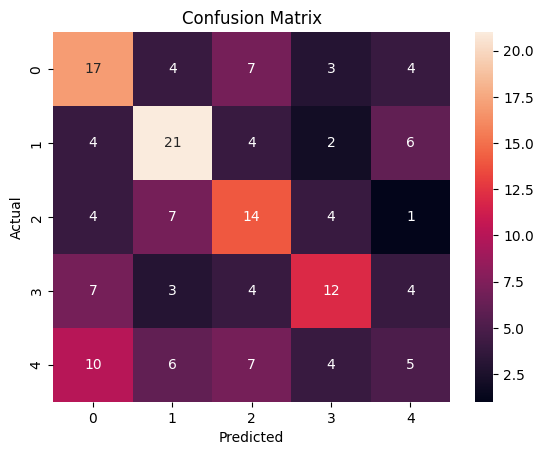

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

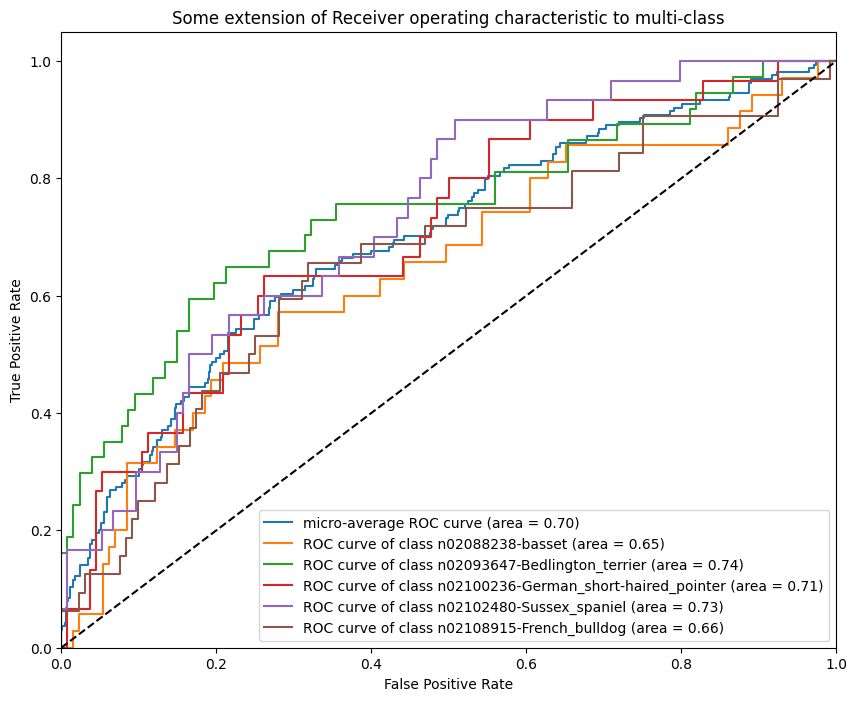

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

# Assuming you have your test targets in y_test and your predicted probabilities in y_pred_proba
# And your classes are [0, 1, 2, 3, 4]

# Binarize the output
# Get the unique classes in y_test
classes = np.unique(y_test)
y_pred_proba = logistic_reg.predict_proba(X_test)

# Binarize the output
y_ = label_binarize(y_test, classes=classes)
n_classes = y_.shape[1]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

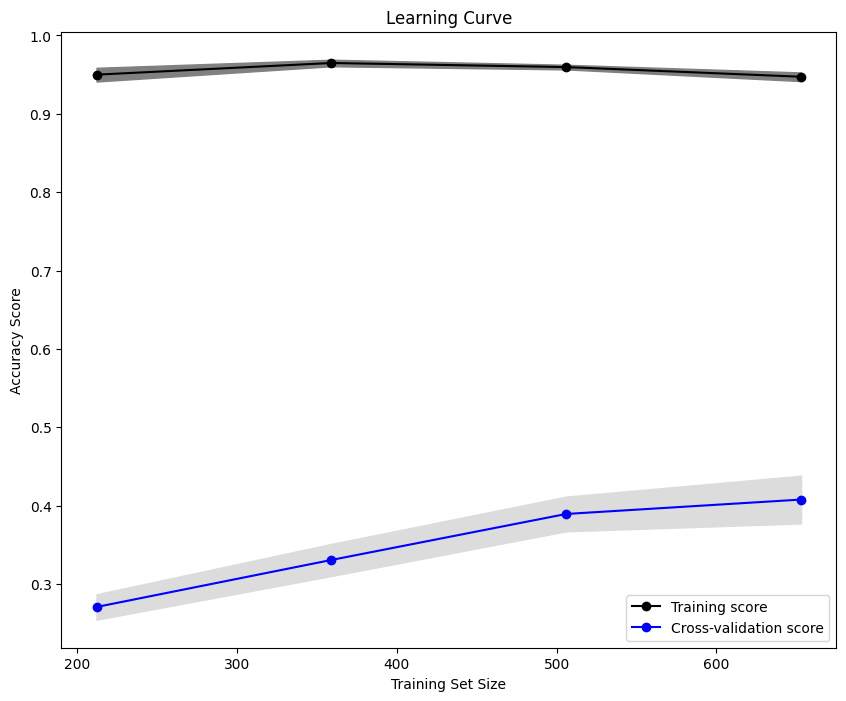

In [20]:
from sklearn.model_selection import learning_curve
# Assuming you have your classifier in 'clf' and your features and targets in 'X' and 'y' respectively
train_sizes, train_scores, test_scores = learning_curve(logistic_reg, X, y, cv=5)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 8))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.plot(train_sizes, train_mean, 'o-', color="black", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="blue", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.show()

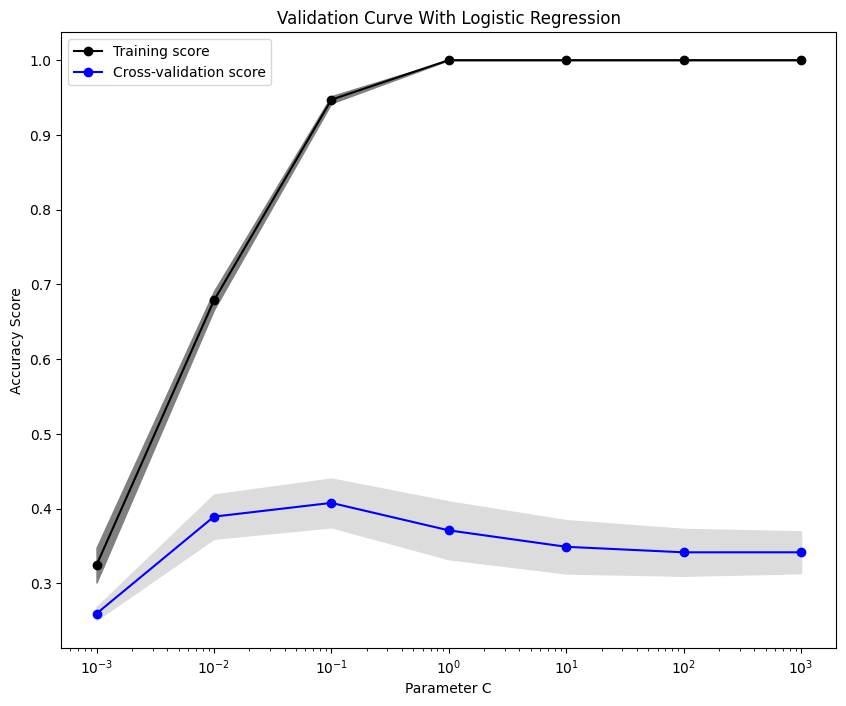

In [21]:
from sklearn.model_selection import validation_curve

# Define range for the 'C' parameter
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(logistic_reg, X, y, param_name="C", param_range=param_range, cv=5)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(10, 8))
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")
plt.plot(param_range, train_mean, 'o-', color="black", label="Training score")
plt.plot(param_range, test_mean, 'o-', color="blue", label="Cross-validation score")
plt.title("Validation Curve With Logistic Regression")
plt.xlabel("Parameter C")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.xscale('log')
plt.show()